In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.ranker import generate_ranker_features

PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG["ranker"]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG['ranker']['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-10-23 02:39:59.754944: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-23 02:40:00.056004: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-23 02:40:01.219764: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_098


In [2]:
oof = pd.read_parquet(f'/kaggle/output/{CFG["patch_model"]["execution"]["best_exp_id"]}/oof.parquet')
sub = pd.read_csv(f'/kaggle/output/{CFG["patch_model"]["execution"]["best_exp_id"]}/submission.csv')
# sub.drop(columns=["oof_stage2"], inplace=True)
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
display(oof.head())
display(sub.head())
display(labels.head())

,series_id,step,wakeup_oof,onset_oof
0,05e1944c3818,6,0.001423,0.000193
1,05e1944c3818,18,0.001385,0.000224
2,05e1944c3818,30,0.001297,0.000247
3,05e1944c3818,42,0.001260,0.000309
4,05e1944c3818,54,0.001197,0.000346


,series_id,step,event,score,reduced_score
0,038441c925bb,202302,wakeup,8.540370,8.540370
1,038441c925bb,118494,wakeup,8.518459,8.518459
2,038441c925bb,219390,wakeup,8.467750,8.467750
3,038441c925bb,40002,onset,8.382386,8.382386
4,038441c925bb,10938,wakeup,8.286556,8.286556


,series_id,night,event,step,timestamp
0,038441c925bb,1,onset,4992.0,2018-08-14T22:26:00-0400
1,038441c925bb,1,wakeup,10932.0,2018-08-15T06:41:00-0400
2,038441c925bb,2,onset,20244.0,2018-08-15T19:37:00-0400
3,038441c925bb,2,wakeup,27492.0,2018-08-16T05:41:00-0400
4,038441c925bb,3,onset,39996.0,2018-08-16T23:03:00-0400


0.9727803860198228


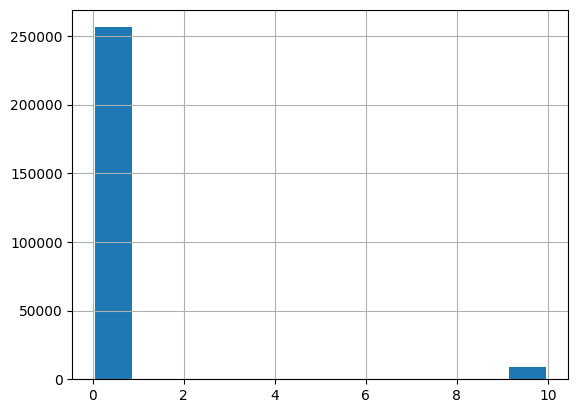

In [3]:
# 正解ラベルを作成
thresholds = [12, 36, 60, 90, 120, 150, 180, 240, 300, 360]
dfs = []
for (series_id, event), label_df in labels.groupby(["series_id", "event"]):
    sub_df = sub[(sub["series_id"] == series_id) & (sub["event"] == event)].reset_index(drop=True)
    targets = np.zeros(len(sub_df))
    for thresh in thresholds:
        matched = np.zeros(len(sub_df), dtype=bool)
        for step in label_df["step"].values:
            min_dist = thresh
            min_idx = -1            
            for idx, sub_step in enumerate(sub_df["step"].values):
                if matched[idx]:
                    continue
                dist = abs(step - sub_step)
                if dist < min_dist:
                    min_dist = dist
                    min_idx = idx
            if min_idx != -1:
                targets[min_idx] += 1
                matched[min_idx] = True
    sub_df["target"] = targets
    sub_df["sub_step"] = sub_df["step"].values
    dfs.append(sub_df)
sub = pd.concat(dfs).reset_index(drop=True)
print(sub["target"].sum() / labels.shape[0] / 10)
plt.hist(sub["target"].values, bins=11, rwidth=0.9)
plt.grid()
plt.show()

In [4]:
wakeup_sub = sub[sub["event"]=="wakeup"].rename(columns={"reduced_score": "wakeup_score", "target": "wakeup_target"})
wakeup_sub["for_wakeup"] = True
oof = oof.merge(wakeup_sub[["series_id", "step", "wakeup_score", "for_wakeup", "wakeup_target"]], on=["series_id", "step"], how="left")

onset_sub = sub[sub["event"]=="onset"].rename(columns={"reduced_score": "onset_score", "target": "onset_target"})
onset_sub["for_onset"] = True
oof = oof.merge(onset_sub[["series_id", "step", "onset_score", "for_onset", "onset_target"]], on=["series_id", "step"], how="left")
train = oof
train.head()

,series_id,step,wakeup_oof,onset_oof,wakeup_score,for_wakeup,wakeup_target,onset_score,for_onset,onset_target
0,05e1944c3818,6,0.001423,0.000193,NaN,NaN,NaN,NaN,NaN,NaN
1,05e1944c3818,18,0.001385,0.000224,NaN,NaN,NaN,NaN,NaN,NaN
2,05e1944c3818,30,0.001297,0.000247,NaN,NaN,NaN,NaN,NaN,NaN
3,05e1944c3818,42,0.001260,0.000309,NaN,NaN,NaN,NaN,NaN,NaN
4,05e1944c3818,54,0.001197,0.000346,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# 特徴生成
train, features = generate_ranker_features(train)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

100%|██████████| 277/277 [05:33<00:00,  1.20s/it]


,series_id,step,wakeup_oof,onset_oof,wakeup_score,for_wakeup,wakeup_target,onset_score,for_onset,onset_target,...,onset_oof_diff_rolling_max_50_shift_100_diff,wakeup_oof_rolling_min_50_shift_100_diff,onset_oof_rolling_min_50_shift_100_diff,wakeup_oof_diff_rolling_min_50_shift_100_diff,onset_oof_diff_rolling_min_50_shift_100_diff,wakeup_oof_rolling_square_mean_50_shift_100_diff,onset_oof_rolling_square_mean_50_shift_100_diff,wakeup_oof_diff_rolling_square_mean_50_shift_100_diff,onset_oof_diff_rolling_square_mean_50_shift_100_diff,fold
0,038441c925bb,270,0.334671,0.000286,0.126556,True,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,038441c925bb,474,2.082744,0.000810,0.051341,True,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
2,038441c925bb,486,2.280902,0.000843,0.495848,True,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
3,038441c925bb,498,2.388275,0.000776,0.097084,True,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,038441c925bb,594,3.196654,0.001443,0.073637,True,0.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


(265771, 1158)

In [9]:
train.loc[train["for_onset"]==True, "event"] = "onset"
train.loc[train["for_wakeup"]==True, "event"] = "wakeup"
train.loc[train["for_onset"]==True, "target"] = train.loc[train["for_onset"]==True, "onset_target"]
train.loc[train["for_wakeup"]==True, "target"] = train.loc[train["for_wakeup"]==True, "wakeup_target"]

In [12]:
train["for_onset"] = train["for_onset"].astype(float)
train["for_wakeup"] = train["for_wakeup"].astype(float)

In [14]:
# 学習
trn_oof, models = fit_xgb(
    X=train, 
    y=train["target"], 
    folds=train["fold"].astype(int), 
    features=features.all_features(),
    params=CFG["ranker"]["xgboost"], 
    es_rounds=100,
)
train["score"] = trn_oof
sub = train[["score", "step", "event", "series_id"]]

# 保存
for i, model in enumerate(models):
    model.save_model(os.path.join(CFG["output_dir"], f'xgb_fold{i}.model'))
with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
sub.to_csv(os.path.join(CFG["output_dir"], "submission.csv"), index=False)

In [15]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)
print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7166


event   tolerance
onset   12           0.295326
        36           0.612896
        60           0.684791
        90           0.721004
        120          0.756305
        150          0.770627
        180          0.788439
        240          0.802322
        300          0.810327
        360          0.817299
wakeup  12           0.373732
        36           0.627496
        60           0.694281
        90           0.726328
        120          0.759932
        150          0.775814
        180          0.796116
        240          0.822467
        300          0.841911
        360          0.854616
dtype: float64